In [228]:
import pandas as pd
import numpy as np
import datetime as dt
import numpy as np

from dateutil import parser

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [229]:
%matplotlib inline

Field legend: 

created – time when the 1st time order request was created.

device_name – name of the device used to make order

device_os_version – version of the device OS

country – 2 char country code

city_id – internal system city ID (not relevant which one is which)

lat – latitude of the pickup spot for the order

lng – longitude of the pickup spot for the order

real_destination_lat – latitude of the destination for the order

real_destination_lng – longitude of the destination for the order

user_id – internal user ID

order_id – internal order ID

order_try_id – internal order try ID (order tries happen before client and driver are matched to an order)

distance – driver distance to the client pickup location, in meters

ride_distance – trip distance in meters

price – price charged to client, can be lower than “ride_price” if client had a discount, currencies vary and are 
undefined

ride_price – calculated price of the final trip, currencies vary and are undefined
price_review_status – “Price review” is when we send “ride_price” to be audited by human to check for system errors. 

99% of orders are final and should have “ok” already set. There might be some that are still in pending states, most likely you can discard those.

price_review_reason – automatic or manual reason for the price review to be requested.

is_successful_payment – 1 means order was charged successfully, 0 mean it has failed (including after all attempts to re-charge)

name – card details, irrelevant.

card_bin – details on card BIN.

failed_attempts – number of failed order attempts before this 1st finished order.

# Action plan

In order to prevent such cases, I would recommend to implement beforehead payment in certain situations.

At first we will look closely at our data and find out which of them we can use both effective and easy, and after that we'll train simple model in order to predict unsuccessful payments and see, how it goes.

# Data Research & analysis

At first, let us just get familiar with our data and calculate some statistic.

In [200]:
df = pd.read_csv('/Users/edenike/Desktop/1st_adyen_rides-success-and-fail.csv')

In [201]:
df.head()

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,distance,ride_distance,price,ride_price,price_review_status,price_review_reason,is_successful_payment,name,card_bin,failed_attempts
0,2016-01-23 23:10:07,motorolaXT1562,motorola6.0.1,ee,2.0,58.378220,26.710402,58.363243,26.737696,218,...,773,3017,4.5000,4.5000,ok,NaN,1,**** 0810,NaN,0
1,2016-05-04 06:01:32,iPhone6,iOS10.3.3,ee,1.0,59.424130,24.646359,59.397548,24.660957,266,...,43,4241,4.4000,4.4000,ok,NaN,1,**** 9115,NaN,0
2,2016-08-27 16:42:22,HTCHTC 10,HTC7.0,ee,1.0,59.413508,24.743706,59.448500,24.804887,551,...,1654,6347,7.2000,7.2000,ok,NaN,1,**** 0634,516903.0,0
3,2016-10-25 07:14:27,iPhone6S,iOS10.3.2,ee,1.0,59.419938,24.744795,59.431686,24.720801,798,...,883,2638,3.1000,3.1000,ok,NaN,1,**** 8730,541747.0,0
4,2016-09-09 12:46:47,"iPhone5,2",iOS9.3.4,ee,1.0,59.471328,24.890557,59.427836,24.774460,944,...,1109,10288,9.0999,9.0999,ok,NaN,1,**** 3503,NaN,0


In [202]:
df.shape #size of our dataset

(304053, 22)

In [203]:
pd.isnull(df).sum() #information about empty cells

created                       0
device_name                   0
device_os_version             0
country                       1
city_id                     319
lat                           0
lng                           0
real_destination_lat         27
real_destination_lng         27
user_id                       0
order_id                      0
order_try_id                  0
distance                      0
ride_distance                 0
price                         0
ride_price                    0
price_review_status           0
price_review_reason      302945
is_successful_payment         0
name                          0
card_bin                   6578
failed_attempts               0
dtype: int64

Let's see a bit of statistic and clear our date from weird/rare values

In [204]:
Counter(df['device_name']).most_common() #statistic about device names (name - quantity)

[('iPhone6', 25509),
 ('iPhone6S', 25259),
 ('iPhone7', 21400),
 ('iPhone5S', 16147),
 ('iPhoneSE', 10155),
 ('iPhone7Plus', 8011),
 ('samsungSM-G935F', 6753),
 ('iPhone7,2', 6262),
 ('samsungSM-G920F', 5762),
 ('samsungSM-G930F', 5630),
 ('iPhone8,1', 4942),
 ('iPhone5', 4594),
 ('HUAWEIALE-L21', 4382),
 ('iPhone6SPlus', 4208),
 ('samsungSM-G925F', 4002),
 ('iPhone6Plus', 3854),
 ('iPhone6,2', 3629),
 ('samsungSM-G900F', 3282),
 ('samsungSM-A510F', 2455),
 ('HUAWEIHUAWEI VNS-L21', 2325),
 ('samsungSM-A310F', 2076),
 ('samsungSM-J500F', 2043),
 ('LGENexus 5X', 2023),
 ('HUAWEIHUAWEI VNS-L31', 1990),
 ('iPhone9,3', 1932),
 ('samsungSM-G950F', 1885),
 ('samsungSM-A500FU', 1740),
 ('HUAWEIEVA-L19', 1679),
 ('OnePlusONEPLUS A3003', 1644),
 ('iPhone4S', 1468),
 ('iPhone5,2', 1394),
 ('iPhone8,4', 1365),
 ('samsungGT-I9505', 1315),
 ('samsungSM-J510FN', 1267),
 ('LGENexus 5', 1248),
 ('SonyD5803', 1232),
 ('iPhone5C', 1227),
 ('SonyE5823', 1176),
 ('samsungGT-I9500', 1159),
 ('samsungSM-A520

In [209]:
Counter(df.country).most_common() #statistic about city id's names (name - quantity)

[('za', 78694),
 ('lv', 55707),
 ('ee', 43780),
 ('hu', 23137),
 ('lt', 20862),
 ('ro', 18127),
 ('ge', 12795),
 ('cz', 9648),
 ('ua', 7652),
 ('az', 7010),
 ('mx', 6798),
 ('pl', 6037),
 ('sk', 4888),
 ('ke', 3427),
 ('rs', 3006),
 ('mt', 1045),
 ('eg', 501),
 ('ng', 483),
 ('fi', 397),
 ('gh', 56)]

In [210]:
df = df[df['country'] != 'ca']
df = df[df['country'] != 'sa']
df.dropna(subset = ['country'], inplace = True)

In [211]:
Counter(df.card_bin).most_common() #statistic about city id's names (name - quantity)

[(557367.0, 13623),
 (516737.0, 12997),
 (528497.0, 10906),
 (412752.0, 9751),
 (557368.0, 9662),
 (484162.0, 8908),
 (516867.0, 6889),
 (516793.0, 5801),
 (425603.0, 5036),
 (479012.0, 4746),
 (516897.0, 4434),
 (516744.0, 3109),
 (532180.0, 3105),
 (541264.0, 2477),
 (541282.0, 2398),
 (420573.0, 2330),
 (547025.0, 2265),
 (485442.0, 2166),
 (528058.0, 2110),
 (522250.0, 2042),
 (535924.0, 1969),
 (400974.0, 1916),
 (466286.0, 1864),
 (448385.0, 1739),
 (516746.0, 1731),
 (543740.0, 1730),
 (490136.0, 1727),
 (477573.0, 1632),
 (516875.0, 1592),
 (414049.0, 1553),
 (440577.0, 1419),
 (412722.0, 1413),
 (532657.0, 1348),
 (490115.0, 1313),
 (539123.0, 1265),
 (557014.0, 1252),
 (445143.0, 1237),
 (451161.0, 1228),
 (516883.0, 1196),
 (415231.0, 1194),
 (420150.0, 1156),
 (543758.0, 1137),
 (533155.0, 1126),
 (468918.0, 1099),
 (431570.0, 1095),
 (516844.0, 1089),
 (477548.0, 1070),
 (526440.0, 1047),
 (457896.0, 1044),
 (402167.0, 1029),
 (448008.0, 1023),
 (414720.0, 1011),
 (516903.

As we can see, we have quite a lot of useful information in our dataset, and we have quite big clusters of cities, countries, and device names. We will definetly work with this information later.

Let us know take a quick look our numeric factors:

In [212]:
df.groupby('is_successful_payment').mean()

,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,order_id,order_try_id,distance,ride_distance,price,ride_price,card_bin,failed_attempts
is_successful_payment,,,,,,,,,,,,,,
0,133.776105,25.568712,18.705376,25.569782,18.705279,1.131548e+06,1.318676e+07,1.354559e+07,1660.255507,9317.337349,84.042277,132.110299,490886.454507,0.525490
1,70.676221,31.809023,24.468750,31.809999,24.470370,1.036690e+06,1.413217e+07,1.450882e+07,1613.988845,9462.178763,316.900821,330.192211,495035.601282,0.318795


We can see, that price/ride_price, counry/city_id average is significantly different for successful/unsuccessful payments, so we want to look closer on that. This difference we can also see for a number of failed attempts, but it does not seems to be very useful, since it happens right before payment.

In [213]:
#since we cannot use it before our ride, let's drop this data
del df['failed_attempts']

In [214]:
df['ride_distance'].describe()

count    3.040500e+05
mean     9.424530e+03
std      1.078288e+04
min      1.000000e+00
25%      4.043000e+03
50%      6.941000e+03
75%      1.156200e+04
max      1.000211e+06
Name: ride_distance, dtype: float64

In [215]:
df[df['ride_distance'] > 200000]

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,order_try_id,distance,ride_distance,price,ride_price,price_review_status,price_review_reason,is_successful_payment,name,card_bin
22934,2016-04-29 07:23:05,samsungGT-I9300,samsung4.3,cz,271.0,50.080684,14.429442,50.083953,14.453403,565419,...,5069983,178,364345,4655.0000,4655.0000,ok,price_too_high,1,**** 7192,516872.0
24236,2016-05-06 17:25:59,SonyLT25i,Sony4.3,lt,9.0,54.674278,25.201520,54.642961,25.279004,582024,...,5158410,989,216713,123.7000,128.7000,ok,price_too_high,0,**** 3971,NaN
33448,2016-08-01 10:44:39,HUAWEIHUAWEI Y560-L01,HUAWEI5.1.1,za,55.0,-33.921334,18.421489,-34.831556,20.006354,666057,...,6333092,609,239203,1640.0000,1740.0000,ok,price_too_high,1,**** 5900,445121.0
38252,2017-05-27 01:05:29,EnspertBK2021,Enspert4.4.2,az,335.0,40.416609,49.935550,41.813439,48.636142,563879,...,19667698,11,215844,66.4899,66.4899,ok,price_too_high,0,**** 1673,529254.0
40743,2016-06-11 15:38:54,iPhone5,iOS9.1,za,55.0,-33.979450,18.600372,-34.019083,18.590662,614624,...,5623303,5695,202214,0.0000,400.0000,ok,price_too_high,0,**** 0187,455703.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250930,2017-08-05 00:17:14,HisenseHisense C30,Hisense7.0,az,335.0,40.393250,49.923820,40.984498,45.637346,2262381,...,27442673,241,454205,147.5399,152.5399,ok,price_too_high,0,**** 7927,416973.0
259891,2017-08-03 09:38:55,samsungSM-J110F,samsung4.4.4,za,54.0,-26.079893,28.004791,-27.640968,27.245491,1506430,...,27183645,62,366631,3215.0000,3215.0000,requested,price_too_high,0,**** 3541,519123.0
272791,2017-08-06 09:58:00,InfinixInfinix HOT 4 Lite,Infinix6.0,ke,320.0,-1.131972,36.973432,-1.174347,36.915641,2280083,...,27640893,169,253036,8590.0000,8590.0000,requested,price_too_high,0,**** 7192,426684.0
274888,2017-08-06 11:54:06,HUAWEIhi6210sft,HUAWEI5.0.1,ke,320.0,-1.309776,36.810586,-1.098530,37.671295,2280908,...,27652469,20,289192,9600.0000,9600.0000,requested,price_too_high,0,**** 5892,442630.0


In [216]:
df['distance'].describe()

count    304050.000000
mean       1626.014830
std        1827.792122
min           0.000000
25%         509.000000
50%        1112.000000
75%        2125.000000
max       39913.000000
Name: distance, dtype: float64

# Country 

We can see very low success rate in some countries:

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


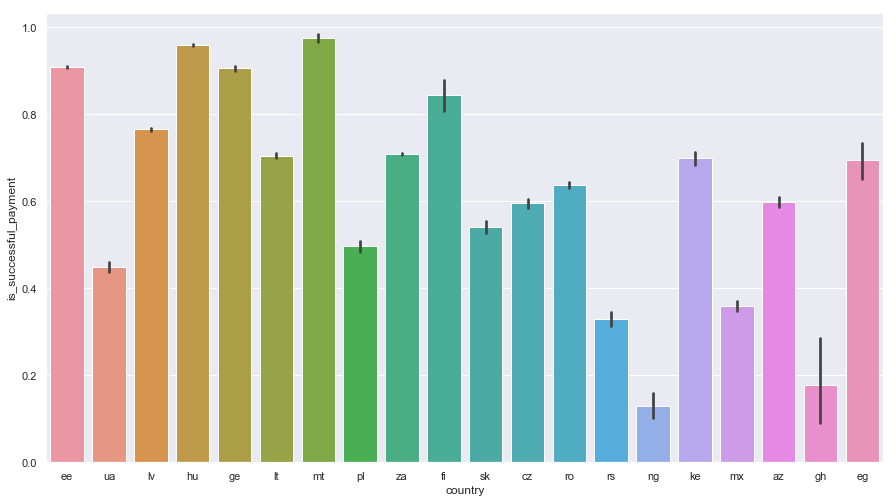

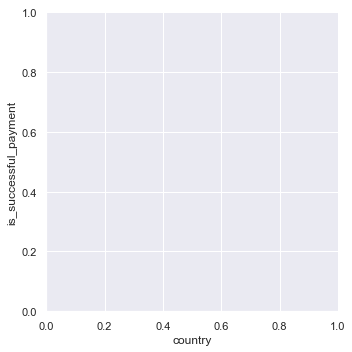

In [230]:
dims = (15, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.factorplot(ax=ax, x = 'country', y = 'is_successful_payment', kind='bar', data = df)

In [219]:
country_analysis = df[['country','is_successful_payment' ]].groupby('country').describe().reset_index()

In [220]:
country_analysis.columns = ['country', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

In [265]:
country_analysis[country_analysis['count'] > 1000][country_analysis['mean'] < 0.7]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,country,count,mean,std,min,25%,50%,75%,max
0,az,7010.0,0.598859,0.490164,0.0,0.0,1.0,1.0,1.0
1,cz,9648.0,0.595460,0.490828,0.0,0.0,1.0,1.0,1.0
8,ke,3427.0,0.699737,0.458439,0.0,0.0,1.0,1.0,1.0
12,mx,6798.0,0.359076,0.479765,0.0,0.0,0.0,1.0,1.0
14,pl,6037.0,0.497267,0.500034,0.0,0.0,0.0,1.0,1.0
15,ro,18127.0,0.638219,0.480529,0.0,0.0,1.0,1.0,1.0
16,rs,3006.0,0.330007,0.470293,0.0,0.0,0.0,1.0,1.0
17,sk,4888.0,0.541735,0.498306,0.0,0.0,1.0,1.0,1.0
18,ua,7652.0,0.449425,0.497468,0.0,0.0,0.0,1.0,1.0


In [267]:
country_analysis[country_analysis['count'] > 1000][country_analysis['mean'] < 0.7].sum()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


country    azczkemxplrorsskua
count                   66593
mean                  4.70979
std                   4.36583
min                         0
25%                         0
50%                         5
75%                         9
max                         9
dtype: object

In [268]:
66593/304053

0.2190177370392662

So, by introducing beforehead payments in this list of countries we can increase our rate of successful rides on 7% approximately

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


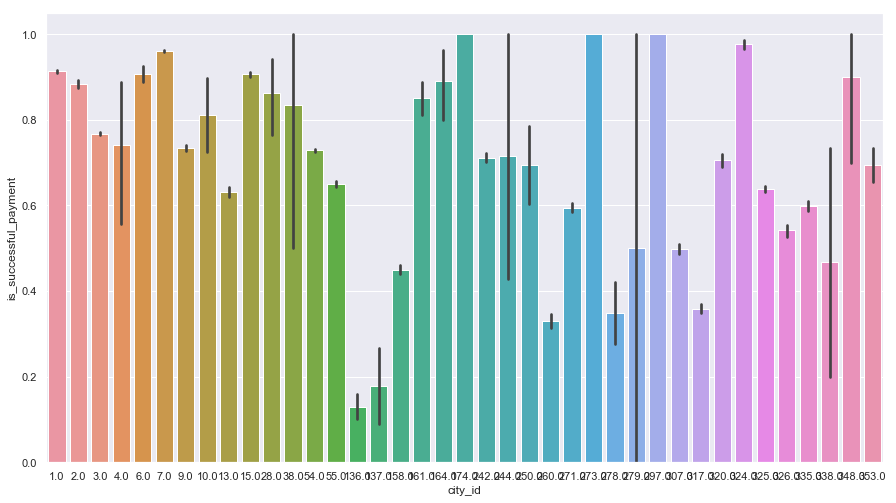

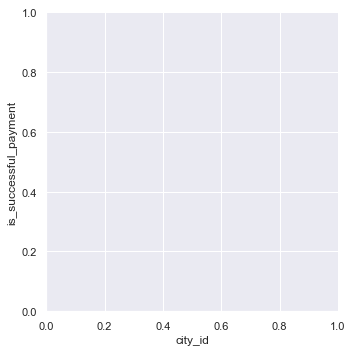

In [227]:
dims = (15, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.factorplot(ax=ax, x = 'city_id', y = 'is_successful_payment', kind='bar', data = df)

In [233]:
city_analysis = df[['city_id','is_successful_payment' ]].groupby('city_id').describe().reset_index()
city_analysis.columns = ['city_id', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

In [235]:
city_analysis[city_analysis['count'] > 1000][city_analysis['mean'] < 0.6]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,city_id,count,mean,std,min,25%,50%,75%,max
16,158.0,7646.0,0.449385,0.497464,0.0,0.0,0.0,1.0,1.0
23,260.0,3004.0,0.330226,0.470373,0.0,0.0,0.0,1.0,1.0
24,271.0,9621.0,0.594741,0.490968,0.0,0.0,1.0,1.0,1.0
29,307.0,5996.0,0.497999,0.500038,0.0,0.0,0.0,1.0,1.0
30,317.0,6795.0,0.359088,0.479768,0.0,0.0,0.0,1.0,1.0
34,326.0,4888.0,0.541735,0.498306,0.0,0.0,1.0,1.0,1.0
35,335.0,7001.0,0.598486,0.490240,0.0,0.0,1.0,1.0,1.0


In [236]:
city_analysis[city_analysis['count'] > 1000][city_analysis['mean'] < 0.6].sum()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


city_id     1974.000000
count      44951.000000
mean           3.371659
std            3.427156
min            0.000000
25%            0.000000
50%            3.000000
75%            7.000000
max            7.000000
dtype: float64

# Phone model

Les us now find out more about phone model. For this we need to clear out data a bit

In [237]:
df.device_os_version

0         motorola6.0.1
1             iOS10.3.3
2                HTC7.0
3             iOS10.3.2
4              iOS9.3.4
              ...      
304048        iOS10.2.1
304049        iOS10.3.2
304050       Boost4.4.2
304051        iOS10.3.2
304052     samsung6.0.1
Name: device_os_version, Length: 304050, dtype: object

Let us at first divide it at iphone/samsung/other users, to make our classification easier

In [238]:
Counter(df.device_name).most_common()

[('iPhone6', 25509),
 ('iPhone6S', 25259),
 ('iPhone7', 21399),
 ('iPhone5S', 16147),
 ('iPhoneSE', 10155),
 ('iPhone7Plus', 8011),
 ('samsungSM-G935F', 6753),
 ('iPhone7,2', 6262),
 ('samsungSM-G920F', 5762),
 ('samsungSM-G930F', 5630),
 ('iPhone8,1', 4942),
 ('iPhone5', 4594),
 ('HUAWEIALE-L21', 4382),
 ('iPhone6SPlus', 4208),
 ('samsungSM-G925F', 4002),
 ('iPhone6Plus', 3854),
 ('iPhone6,2', 3629),
 ('samsungSM-G900F', 3282),
 ('samsungSM-A510F', 2455),
 ('HUAWEIHUAWEI VNS-L21', 2325),
 ('samsungSM-A310F', 2076),
 ('samsungSM-J500F', 2043),
 ('LGENexus 5X', 2023),
 ('HUAWEIHUAWEI VNS-L31', 1990),
 ('iPhone9,3', 1932),
 ('samsungSM-G950F', 1885),
 ('samsungSM-A500FU', 1740),
 ('HUAWEIEVA-L19', 1679),
 ('OnePlusONEPLUS A3003', 1644),
 ('iPhone4S', 1468),
 ('iPhone5,2', 1394),
 ('iPhone8,4', 1365),
 ('samsungGT-I9505', 1315),
 ('samsungSM-J510FN', 1267),
 ('LGENexus 5', 1248),
 ('SonyD5803', 1232),
 ('iPhone5C', 1227),
 ('SonyE5823', 1176),
 ('samsungGT-I9500', 1159),
 ('samsungSM-A520

In [241]:
device_type = []
others = []
for device in df.device_name:
    device = device.lower()
    if 'iphone' in device:
        device_type.append('iphone')
    elif 'samsung' in device:
        device_type.append('samsung')
    elif 'huawei' in device:
        device_type.append('huawei') 
    elif 'xiaomi' in device:
        device_type.append('xiaomi')
    elif 'nexus' in device:
        device_type.append('nexus')
    elif 'sony' in device:
        device_type.append('sony')
    elif 'oneplus' in device:
        device_type.append('oneplusone')
    elif 'lg' in device:
        device_type.append('lg')
    elif 'htc' in device:
        device_type.append('htc')
    elif 'motorola' in device:
        device_type.append('motorola')
    elif 'pixel' in device:
        device_type.append('pixel')
    elif 'asus' in device:
        device_type.append('asus')
    elif 'lenovo' in device:
        device_type.append('lenovo')
    else:
        device_type.append('other')
        others.append(device)

In [242]:
Counter(device_type)

Counter({'motorola': 3019,
         'iphone': 146925,
         'htc': 4498,
         'samsung': 76162,
         'oneplusone': 3816,
         'nexus': 3857,
         'other': 14457,
         'sony': 11371,
         'lg': 6294,
         'huawei': 24659,
         'xiaomi': 4734,
         'pixel': 416,
         'asus': 1259,
         'lenovo': 2583})

In [243]:
#Counter(others).most_common()

In [244]:
df['device_type'] = device_type

In [245]:
device_analysis = df[['device_type','is_successful_payment' ]].groupby('device_type').describe().reset_index()
device_analysis.columns = ['device_id', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

In [246]:
device_analysis

,device_id,count,mean,std,min,25%,50%,75%,max
0,asus,1259.0,0.718824,0.449752,0.0,0.0,1.0,1.0,1.0
1,htc,4498.0,0.676745,0.467771,0.0,0.0,1.0,1.0,1.0
2,huawei,24659.0,0.724482,0.446784,0.0,0.0,1.0,1.0,1.0
3,iphone,146925.0,0.774715,0.417771,0.0,1.0,1.0,1.0,1.0
4,lenovo,2583.0,0.540844,0.498425,0.0,0.0,1.0,1.0,1.0
5,lg,6294.0,0.685574,0.464324,0.0,0.0,1.0,1.0,1.0
6,motorola,3019.0,0.578668,0.493854,0.0,0.0,1.0,1.0,1.0
7,nexus,3857.0,0.755509,0.429840,0.0,1.0,1.0,1.0,1.0
8,oneplusone,3816.0,0.832023,0.373895,0.0,1.0,1.0,1.0,1.0
9,other,14457.0,0.628484,0.483227,0.0,0.0,1.0,1.0,1.0


/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


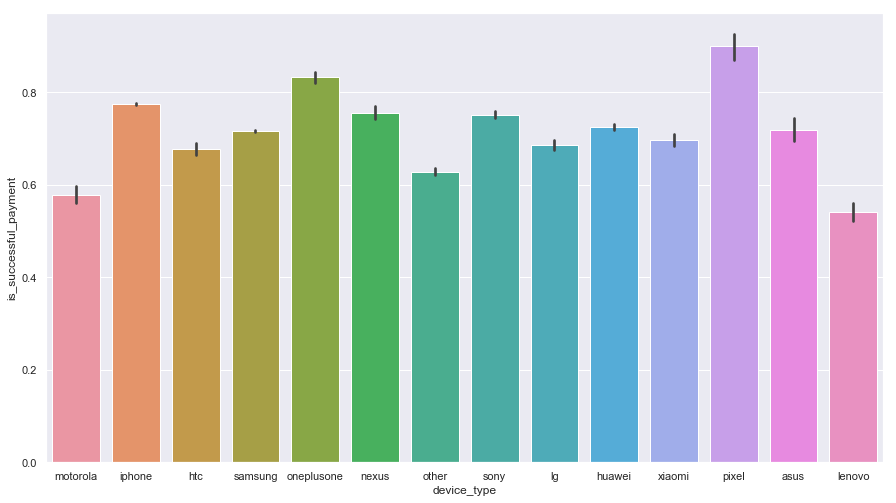

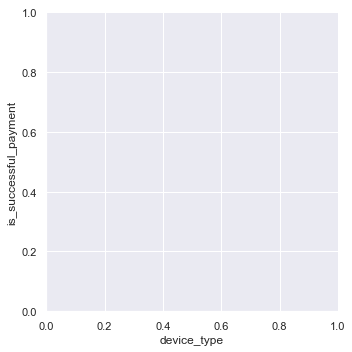

In [247]:
dims = (15, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.factorplot(ax=ax, x = 'device_type', y = 'is_successful_payment', kind='bar', data = df)

In [248]:
device_analysis[device_analysis['mean'] < 0.7]

,device_id,count,mean,std,min,25%,50%,75%,max
1,htc,4498.0,0.676745,0.467771,0.0,0.0,1.0,1.0,1.0
4,lenovo,2583.0,0.540844,0.498425,0.0,0.0,1.0,1.0,1.0
5,lg,6294.0,0.685574,0.464324,0.0,0.0,1.0,1.0,1.0
6,motorola,3019.0,0.578668,0.493854,0.0,0.0,1.0,1.0,1.0
9,other,14457.0,0.628484,0.483227,0.0,0.0,1.0,1.0,1.0
13,xiaomi,4734.0,0.696240,0.459929,0.0,0.0,1.0,1.0,1.0


# Price

In [249]:
set(df.country)

{'az',
 'cz',
 'ee',
 'eg',
 'fi',
 'ge',
 'gh',
 'hu',
 'ke',
 'lt',
 'lv',
 'mt',
 'mx',
 'ng',
 'pl',
 'ro',
 'rs',
 'sk',
 'ua',
 'za'}

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


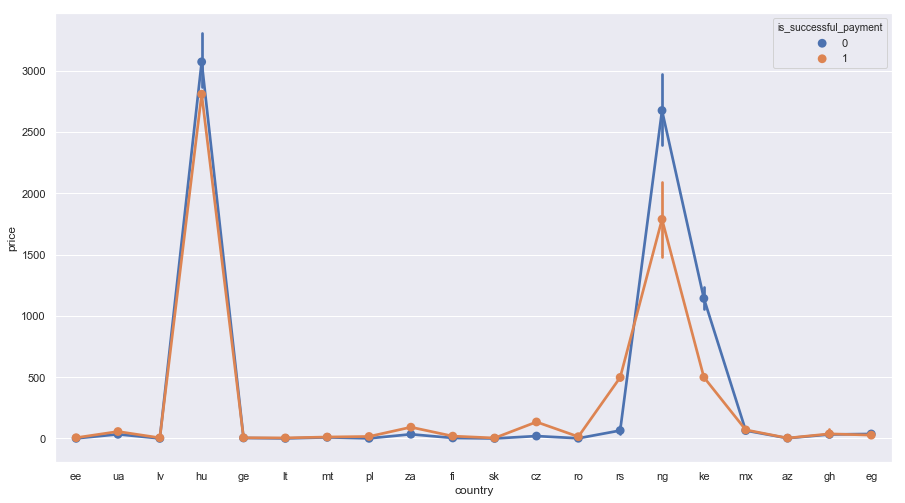

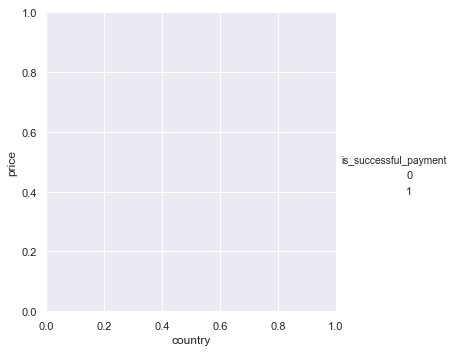

In [251]:
dims = (15, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.factorplot(ax= ax, x = 'country', y='price', hue = 'is_successful_payment', data = df)

As we can see:

    pries varies from country to country (because of currency)
    we can still see difference in price between successfull & unseccessfull paiments
    

# distance

In [163]:
df['distance'].describe()

count    304050.000000
mean       1626.014830
std        1827.792122
min           0.000000
25%         509.000000
50%        1112.000000
75%        2125.000000
max       39913.000000
Name: distance, dtype: float64

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


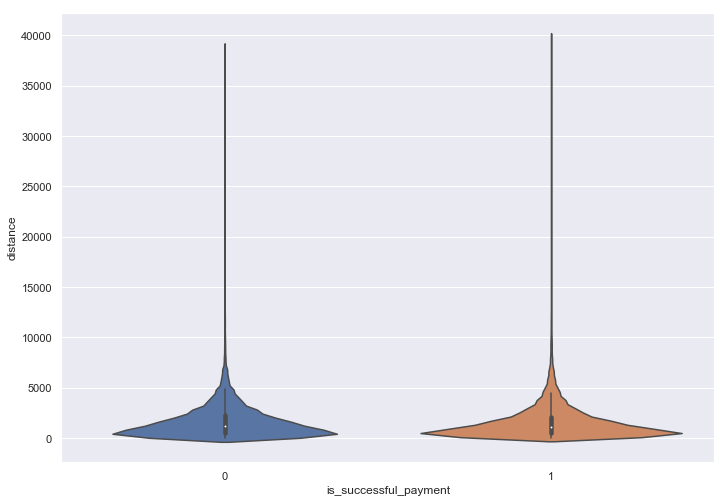

In [162]:
sns.violinplot(x = 'is_successful_payment', y='distance', data = df)

In [170]:
df[['is_successful_payment', 'distance']].groupby('is_successful_payment').describe()

distance                                                \
                          count         mean          std  min    25%     50%   
is_successful_payment                                                           
0                       79031.0  1660.255507  1751.781666  0.0  529.0  1201.0   
1                      225019.0  1613.988845  1853.602761  0.0  503.0  1082.0   

                                        
                          75%      max  
is_successful_payment                   
0                      2262.0  38856.0  
1                      2075.0  39913.0

In [171]:
df[['is_successful_payment', 'ride_distance']].groupby('is_successful_payment').describe()

ride_distance                                          \
                              count         mean           std  min     25%   
is_successful_payment                                                         
0                           79031.0  9317.337349  15161.797415  1.0  4082.0   
1                          225019.0  9462.178763   8738.656467  1.0  4029.0   

                                                   
                          50%      75%        max  
is_successful_payment                              
0                      6596.0  10214.5  1000211.0  
1                      7098.0  12166.0   943617.0

# Card bin

In [253]:
Counter(df.card_bin).most_common()

[(557367.0, 13623),
 (516737.0, 12997),
 (528497.0, 10906),
 (412752.0, 9751),
 (557368.0, 9662),
 (484162.0, 8908),
 (516867.0, 6889),
 (516793.0, 5801),
 (425603.0, 5036),
 (479012.0, 4746),
 (516897.0, 4434),
 (516744.0, 3109),
 (532180.0, 3105),
 (541264.0, 2477),
 (541282.0, 2398),
 (420573.0, 2330),
 (547025.0, 2265),
 (485442.0, 2166),
 (528058.0, 2110),
 (522250.0, 2042),
 (535924.0, 1969),
 (400974.0, 1916),
 (466286.0, 1864),
 (448385.0, 1739),
 (516746.0, 1731),
 (543740.0, 1730),
 (490136.0, 1727),
 (477573.0, 1632),
 (516875.0, 1592),
 (414049.0, 1553),
 (440577.0, 1419),
 (412722.0, 1413),
 (532657.0, 1348),
 (490115.0, 1313),
 (539123.0, 1265),
 (557014.0, 1252),
 (445143.0, 1237),
 (451161.0, 1228),
 (516883.0, 1196),
 (415231.0, 1194),
 (420150.0, 1156),
 (543758.0, 1137),
 (533155.0, 1126),
 (468918.0, 1099),
 (431570.0, 1095),
 (516844.0, 1089),
 (477548.0, 1070),
 (526440.0, 1047),
 (457896.0, 1044),
 (402167.0, 1029),
 (448008.0, 1023),
 (414720.0, 1011),
 (516903.

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


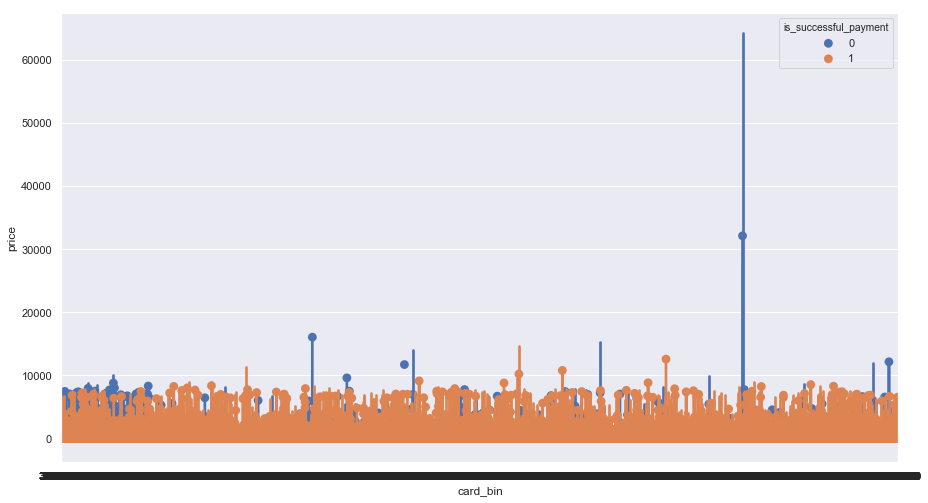

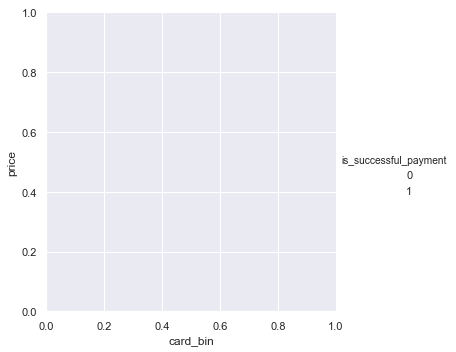

In [254]:
dims = (15, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.factorplot(ax = ax, x = 'card_bin', y='price', hue = 'is_successful_payment', data = df)

In [255]:
cardbin_analysis = df[['card_bin','is_successful_payment' ]].groupby('card_bin').describe().reset_index()
city_analysis.columns = ['card_bin', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

In [261]:
city_analysis[city_analysis['count']>100].sort_values(by='mean', ascending = False)

,card_bin,count,mean,std,min,25%,50%,75%,max
32,324.0,1035.0,0.976812,0.150574,0.0,1.0,1.0,1.0,1.0
5,7.0,23137.0,0.959632,0.196826,0.0,1.0,1.0,1.0,1.0
0,1.0,38227.0,0.912758,0.282193,0.0,1.0,1.0,1.0,1.0
4,6.0,912.0,0.906798,0.290874,0.0,1.0,1.0,1.0,1.0
9,15.0,12781.0,0.905954,0.291904,0.0,1.0,1.0,1.0,1.0
1,2.0,4400.0,0.882727,0.321782,0.0,1.0,1.0,1.0,1.0
17,161.0,328.0,0.850610,0.357017,0.0,1.0,1.0,1.0,1.0
2,3.0,55468.0,0.767614,0.422358,0.0,1.0,1.0,1.0,1.0
6,9.0,14870.0,0.734835,0.441436,0.0,0.0,1.0,1.0,1.0
12,54.0,54485.0,0.728586,0.444693,0.0,0.0,1.0,1.0,1.0


In [262]:
city_analysis[city_analysis['count']>100][city_analysis['mean'] < 0.7]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,card_bin,count,mean,std,min,25%,50%,75%,max
8,13.0,5876.0,0.631722,0.482378,0.0,0.0,1.0,1.0,1.0
13,55.0,18034.0,0.650161,0.476932,0.0,0.0,1.0,1.0,1.0
14,136.0,482.0,0.128631,0.335139,0.0,0.0,0.0,0.0,1.0
16,158.0,7646.0,0.449385,0.497464,0.0,0.0,0.0,1.0,1.0
23,260.0,3004.0,0.330226,0.470373,0.0,0.0,0.0,1.0,1.0
24,271.0,9621.0,0.594741,0.490968,0.0,0.0,1.0,1.0,1.0
26,278.0,181.0,0.348066,0.477679,0.0,0.0,0.0,1.0,1.0
29,307.0,5996.0,0.497999,0.500038,0.0,0.0,0.0,1.0,1.0
30,317.0,6795.0,0.359088,0.479768,0.0,0.0,0.0,1.0,1.0
33,325.0,18118.0,0.638205,0.480533,0.0,0.0,1.0,1.0,1.0


In [264]:
city_analysis[city_analysis['count']>100][city_analysis['mean'] < 0.7].sum()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


card_bin     3134.000000
count       88143.000000
mean            6.463055
std             6.140849
min             0.000000
25%             0.000000
50%             7.000000
75%            12.000000
max            13.000000
dtype: float64

# Machine learning model

Actually the best way to predict best possible outcome in this situation we may use machine learning model. I am going to use CtBoost model as it very effective and super easy to use.

In [181]:
#!pip install catboost
#!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [182]:
df.shape[0]*0.8 #80% on a training 

243240.0

In [183]:
df_train = df[:242987]

In [184]:
df_test = df[242987:]

In [185]:
df_test.fillna(-999, inplace=True)
df_train.fillna(-999, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [186]:
X = df_train.drop('is_successful_payment', axis=1)
y = df_train.is_successful_payment

In [187]:
print(X.dtypes)

categorical_features_indices = np.where(X.dtypes != np.float)[0]

created                  object
device_name              object
device_os_version        object
country                  object
city_id                 float64
lat                     float64
lng                     float64
real_destination_lat    float64
real_destination_lng    float64
user_id                   int64
order_id                  int64
order_try_id              int64
distance                  int64
ride_distance             int64
price                   float64
ride_price              float64
price_review_status      object
price_review_reason      object
name                     object
card_bin                float64
device_type              object
dtype: object


In [189]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = df_test

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [190]:
from sklearn.metrics import accuracy_score

In [191]:
from catboost import CatBoostClassifier, Pool, cv

In [192]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [193]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [194]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.95±0.00 on step 991


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [36]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.9505899559619109


In [38]:
X_test.head()

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,distance,ride_distance,price,ride_price,price_review_status,price_review_reason,is_successful_payment,name,card_bin,failed_attempts
243251,2017-03-04 01:48:34,iPhone7,iOS10.2.1,cz,271.0,50.090603,14.425844,50.071952,14.404195,1277360,...,797,5709,0.0000,90.0000,ok,-999,0,**** 1624,440752.0,0
243252,2017-07-27 00:17:11,TCL9001D,TCL6.0.1,lv,3.0,56.951310,24.127137,56.944727,24.206562,2184210,...,211,5894,4.0999,4.0999,ok,-999,0,**** 5965,427655.0,0
243253,2017-06-28 01:42:08,iPhone7Plus,iOS10.3.2,ee,1.0,59.439731,24.879234,59.416575,24.798247,129652,...,399,7076,7.0000,7.0000,ok,-999,1,**** 6328,516867.0,1
243254,2016-10-28 20:46:59,samsungSM-J120F,samsung5.1.1,za,54.0,-26.045020,28.064529,-26.145620,28.036414,724063,...,735,19787,150.0000,150.0000,ok,-999,1,**** 6022,412752.0,0
243255,2017-05-24 22:20:31,HTCOne Mini 2,HTC5.1.1,ee,1.0,59.414157,24.642439,59.413369,24.691013,338752,...,1668,3857,3.8999,3.8999,ok,-999,1,**** 6287,516737.0,0


In [40]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

In [41]:
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

price: 36.55339445722883
card_bin: 12.17530883305111
country: 6.997303502520888
lat: 5.36911322920201
device_name: 5.013099394762747
real_destination_lat: 4.938369999484962
device_os_version: 4.874072482626094
real_destination_lng: 4.176686434410922
distance: 3.4794420678107385
ride_price: 3.010806325922598
lng: 3.0042688271643665
name: 2.950506650994644
failed_attempts: 2.553167260658132
ride_distance: 1.9247691601704755
price_review_reason: 1.2319558823136518
city_id: 1.012064729309379
price_review_status: 0.6291136199235304
created: 0.10305654958373556
order_id: 0.003500592861169647
user_id: 0.0
order_try_id: 0.0
